<font size=8> **Plotting sea ice in the Southern Ocean** </font>  
  
This notebooks examines sea ice area concentration (SIC), sea ice extent (SIE) and total area of marginal ice zone (MIZ) in the Southern Ocean using outputs from ACCESS-OM2-01.  
  
Comparison with observations was done using the [NASA Goddard-merged Near Real Time NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration](https://climatedataguide.ucar.edu/climate-data/sea-ice-concentration-data-nasa-goddard-and-nsidc-based-nasa-team-algorithm) (version 3). Note that the observations have data missing on some dates before February 1988, therefore we had to replace the missing dates with some interpolated data. This process is described in full in the [Sea Ice Seasonality notebook](https://github.com/lidefi87/ACCESS-OM2-01_EcologicallyRelevantVariables/blob/main/Scripts/SeaIceSeasonality.ipynb).

The two datasets (model and observations) used in this notebook can be found in GADI.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
os.chdir(os.path.expanduser('~/ACCESS-OM2-01_EcologicallyRelevantVariables/Scripts'))

You can print your working directory using the chunk below to make sure you are in the correct folder containing these notebooks.

In [ ]:
!pwd

# Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [2]:
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, progress
from glob import glob
import calendar
#Importing script containing functions developed to calculate timeseries
import ZonalStatsFunctions as zsf
import datetime as dt
import xesmf as xe
import rioxarray
from itertools import cycle
import string

The following modules are used in plotting maps and time series.

In [3]:
#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.gridspec as gridspec
import geopandas

#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

# Accessing ACCESS-OM2-01 outputs
We will start a cluster that has multiple cores to work with and make analyses faster. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
  
If the line below does not run, you can skip it. The result is that the job will not be parallelised, but the script will still run.

In [3]:
client = Client()

We will now need to a new start in the COSIMA cookbook, which will give us access to the default ACCESS-OM2 experiment database from where we will load the data of our interest.

In [5]:
session = cc.database.create_session()

## Set up dictionary of variables prior accessing ACCESS-OM2 model outputs
The dictionary below contains a list of variables containing information that will be used multiple times throughout this notebook. Largely these are file paths to folders where data is either stored or saved. Ensure you update these variables based on your needs.

In [4]:
varDict =  {'var_id': 'aice_m',
            'model': 'ACCESS-OM2-01',
             'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
             'freq': '1 monthly',
             'start_date': range(1965, 2018, 1),
             'long_name': 'sea ice area',
             'short_name': 'SIA',
             'unit': '$m^2$',
             'CICE_data': True,
             'base_data': r'/g/data/v45/la6889/Calculations/SeaIceArea/Data',
             'linear_trends': r'/g/data/v45/la6889/Calculations/SeaIceArea/LinearTrends',
             'lm_fig': r'/g/data/v45/la6889/Figures/SeaIceArea/LinearTrends',
             'clipped_data': r'/g/data/v45/la6889/Calculations/SeaIceArea/ClippedMEASOregions/',
             'decades': range(1965, 2019, 10)}

# Loading ACCESS-OM2 outputs for Sea Ice Concentration in the Southern Ocean
We will use the COSIMA Cookbook to search and load the SIC data we need, we will then extract data for the Southern Ocean only, correct the longitude values, and finally save it to our disk to avoid having to apply this step every time we need access to this data.

In [7]:
dir_out = varDict['base_data']
os.makedirs(dir_out, exist_ok = True)

for yr in varDict['decades']:
    #Accessing data per decade
    stime = f'{str(yr)}-01'
    etime = f'{str(yr+9)}-12'
    #Accessing ACCESS 0.1deg outputs for the entire time range of interest
    SO = zsf.getACCESSdata(varDict['var_id'], stime, etime,
                           freq = varDict['freq'], 
                           ses = session, minlat = -80, maxlat = -35,
                           ice_data = varDict['CICE_data'])
    #Correcting longitudes
    SO = zsf.corrlong(SO)
    #Creating name of file    
    fn = f'SeaIceConcentration_{str(yr)}-{str(yr+9)}.nc'
    #Saving file
    SO.to_netcdf(os.path.join(dir_out, fn))

## Loading longitude corrected sea ice concentration data saved in previous step
SIC less than 0.1 were removed from model ouputs to match the algorithm used in the NASA Goddard data, which considers pixels with SIC estimates less than 0.1 as open water (see page 30 of [User Guide](https://nsidc.org/data/g02202/versions/3)).

In [5]:
#Concantenating all files into a single data array
SIC = xr.open_mfdataset(glob(os.path.join(varDict['base_data'], '*Conc*.nc'))).aice_m
SIC = SIC.sel(time = slice('1978-12', '2018-11'))
SIC

<xarray.DataArray 'aice_m' (time: 480, yt_ocean: 844, xt_ocean: 3600)>
dask.array<getitem, shape=(480, 844, 3600), dtype=float32, chunksize=(120, 844, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1978-12-31T12:00:00 ... 2018-11-30T12:00:00
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -35.2 -35.12 -35.04
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-08-20
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...
    coordinates:    TLON TLAT time

# Loading MEASO regions to overlay them on plots

<AxesSubplot:>

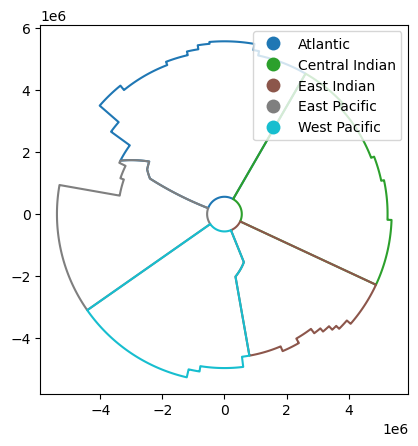

In [6]:
#Load shapefile
MEASO = geopandas.read_file('../SupportingData/MEASO/measo.shp')

#Remove temperate zones as they are not within area of interest
MEASO = MEASO.query('zone != "Temperate"')

#Get sector names from shapefile
sectors = np.unique(MEASO.sector)

#Merge sectors within regions as sea ice is mostly within Antarctic areas
for i, sec in enumerate(sectors):
    pol = MEASO.query(f'sector == "{sec}"').geometry.unary_union
    pol_gs = geopandas.GeoSeries(pol).exterior
    if i == 0:
        MEASO_fixed = pol_gs
    else:
        MEASO_fixed = MEASO_fixed.append(pol_gs)

#Transforming geoseries into geodataframe to add region names
#and adding a new column with the names of the sectors
MEASO_fixed = geopandas.GeoDataFrame(geometry = MEASO_fixed).\
assign(sector = sectors)
        
#Checking results
MEASO_fixed.plot(column = 'sector', legend = True)

# Sea Ice Concentration from observations
The observations loaded here were corrected in the [Sea Ice Seasonality notebook](https://github.com/lidefi87/ACCESS-OM2-01_EcologicallyRelevantVariables/blob/main/Scripts/SeaIceSeasonality.ipynb). The observational data is summarised as monthly means to match the model output temporal resolution.

In [12]:
#Loading observations
obs = xr.open_mfdataset(glob('/g/data/v45/la6889/Observations/*.nc')).goddard_merged_seaice_conc
#Subsetting data to match definition of seasons 
obs = obs.sel(time = slice('1978-12', '2018-11'))

#Calculating monthly means to match model data
#Empty variable to store results
iceObs = []
#Looping through each year
for yr, da in obs.groupby('time.year'):
    #Calculating monthly means per year
    mon = da.groupby('time.month').mean('time')
    #Changing month dimension back to time with dates
    time = pd.date_range(f'{yr}-{mon.month.values.min()}', 
                         f'{yr}-{mon.month.values.max()}', freq = 'MS')
    mon = mon.rename({'month': 'time'})
    mon['time'] = time
    #Putting all results in one variable
    iceObs.append(mon)

#Load everything in a single data array and renaming variables prior to regridding
iceObs = xr.concat(iceObs, dim = 'time').rename({'longitude': 'lon', 'latitude': 'lat'})

#Removing variables that are not longer needed
del obs, mon, time

# Comparing model and observations estimates
Note that the model data will be regridded to match the observations before comparisons are performed. SIC less than 0.1 were removed from model ouputs to match the algorithm used in the NASA Goddard data, which considers pixels with SIC estimates less than 0.1 as open water (see page 30 of [User Guide](https://nsidc.org/data/g02202/versions/3)).

## Regridding model outputs (coarsening data)
First, the `x` and `y` axes (containing coordinates) in the data arrays of observations and model data need to be renamed.

In [9]:
mod = SIC.where(SIC >= 0.1).fillna(0).rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})
mod

<xarray.DataArray 'aice_m' (time: 480, lat: 844, lon: 3600)>
dask.array<where, shape=(480, 844, 3600), dtype=float32, chunksize=(120, 844, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1978-12-31T12:00:00 ... 2018-11-30T12:00:00
  * lon      (lon) float64 -179.9 -179.8 -179.7 -179.6 ... 179.7 179.8 179.9
  * lat      (lat) float64 -79.97 -79.93 -79.88 -79.84 ... -35.2 -35.12 -35.04
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-08-20
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...
    coordinates:    TLON TLAT time

Extracting grids for the model data and the observations.

In [10]:
grid_in = {'lon': mod.lon.values, 'lat': mod.lat.values}
grid_out = {'lon': iceObs.lon.values, 'lat': iceObs.lat.values}

Calculating regridder using the information above. Bilinear interpolation chosen.

In [11]:
#We only need to calculate the regridder once
reg_coarse = xe.Regridder(grid_in, grid_out, 'bilinear')

Applying regridder to model and saving regridded data.

2023-03-02 12:51:10,514 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.73 GiB -- Worker memory limit: 4.00 GiB


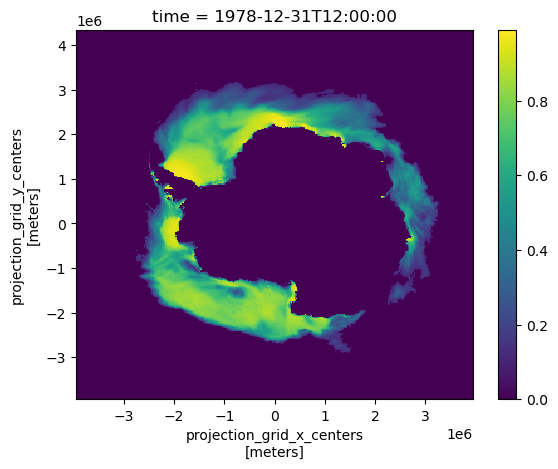

In [12]:
#Applying regridder
reg_mod_all = reg_coarse(mod)
#Renaming and adding same dimensions as observations
reg_mod_all = reg_mod_all.rename({'y': 'ygrid'}).rename({'x': 'xgrid'})
reg_mod_all = reg_mod_all.assign_coords({'ygrid': iceObs.ygrid}).assign_coords({'xgrid': iceObs.xgrid})

#Checking first time step of regridded data
reg_mod_all[0].plot()

# Calculating Sea Ice Extent (SIE) and total are for Marginal Ice Zone (MIZ)
Sea ice extent is calculated based on Hobbs et al 2016, which is the total area covered where sea ice concentration is 15% or more. MIZ is defined as the area where SIC is between 15% and 80%.  
  
To calculate SIE and MIZ, we need to load the area of the model and observation grids.  

In [7]:
#Loading ice area data (in m2) - Only one file needed as they will be the same regardless of the time
IceArea = xr.open_dataarray('/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/area_per_pixel_01deg_all_areas.nc')

## Model-derived SIE and MIZ

In [9]:
#Ensure output folder exists
folder_out = varDict['base_data']
os.makedirs(folder_out, exist_ok = True)

#Only keep area pixels where sea ice concentration is 15% or more
SIE = xr.where(SIC >= 0.15, IceArea, np.nan)
MIZ = xr.where(((SIC >= 0.15) & (SIC <= 0.8)), IceArea, np.nan)

#Save sea ice extent
fn = f'SeaIceExtent_{SIE.time.dt.year.values.min()}-{SIE.time.dt.year.values.max()}.nc'
SIE.to_netcdf(os.path.join(folder_out, fn))

fn_m = f'MIZ_{MIZ.time.dt.year.values.min()}-{MIZ.time.dt.year.values.max()}.nc'
MIZ.to_netcdf(os.path.join(folder_out, fn_m))

### Loading sea ice extent to avoid recalculating SIE and MIZ

In [5]:
SIE = xr.open_dataarray(glob(os.path.join(varDict['base_data'], '*Ext*.nc'))[0])
SIE = SIE.sel(time = slice('1978-12', '2018-11'))

MIZ = xr.open_dataarray(glob(os.path.join(varDict['base_data'], '*MIZ*.nc'))[0])
MIZ = MIZ.sel(time = slice('1978-12', '2018-11'))

## Observations-derived SIE and MIZ

In [18]:
#Location of observation files
filelist = sorted(glob('/g/data/v45/la6889/Observations/*.nc'))

#Load them as data array
iceObs = []
for yr in range(1978, 2019):
    file = [f for f in filelist if str(yr) in f]
    data = xr.open_dataarray(file[0]).groupby('time.month').mean('time')
    time = pd.date_range(f'{yr}-{data.month.values.min()}', 
                         f'{yr}-{data.month.values.max()}', freq = 'MS')
    data = data.rename({'month': 'time'})
    data['time'] = time
    iceObs.append(data)
iceObs = xr.concat(iceObs, dim = 'time').sel(time = slice('1978-12', '2018-11'))

#Only keep area pixels where sea ice concentration is 15% or more for SIE
SIE_obs = xr.where(iceObs >= 0.15, (25000**2), np.nan)

#Keep area pixels where sea ice concentration is between 15% and 80% for MIZ
MIZ_obs = xr.where(((iceObs >= 0.15) & (iceObs <= 0.8)), (25000**2), np.nan)

# Splitting MIZ and SIE data into MEASO sectors

## Defining sector names
Sector names given in the order we want them to appear in figures.

In [7]:
#Defining sector names in order
sectorNames = ['Atlantic', 'Central Indian', 'East Indian', 'West Pacific', 'East Pacific']

## Loading MEASO mask

In [8]:
#Loading mask
regions = xr.load_dataarray('../SupportingData/Masks/MEASO_SIS_3Dmask.nc')

# #Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for i in sectorNames:
    MEASOregions[i] = regions.sel(region = i)
    
MEASOregions.keys()

dict_keys(['Atlantic', 'Central Indian', 'East Indian', 'West Pacific', 'East Pacific'])

## Splitting model data

In [16]:
#Ensuring output folder exists
out_folder = varDict['clipped_data']
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_SIE = {}
clipped_MIZ = {}

#Range of years included in data
minY = SIE.time.dt.year.values.min()
maxY = SIE.time.dt.year.values.max()

#Saving each sector as an entry in the dictionary
for sector in sectorNames:
    clip = []
    clip_m = []
    for t in SIE.time.values:
        #SIE
        sie_t = SIE.sel(time = t)
        sie_t = (sie_t*MEASOregions[sector]).sum(('xt_ocean', 'yt_ocean'))
        clip.append(sie_t)
        #MIZ
        miz_t = MIZ.sel(time = t)
        miz_t = (miz_t*MEASOregions[sector]).sum(('xt_ocean', 'yt_ocean'))
        clip_m.append(miz_t)
    clipped_SIE[sector] = xr.concat(clip, dim = 'time')
    clipped_MIZ[sector] = xr.concat(clip_m, dim = 'time')
    #Create name for output file
    #SIE
    fn = f'SeaIceExtent_{sector}_{minY}-{maxY}.nc'
    clipped_SIE[sector].to_netcdf(os.path.join(out_folder, fn))
    #MIZ
    fn_m = f'MIZ_{sector}_{minY}-{maxY}.nc'
    clipped_MIZ[sector].to_netcdf(os.path.join(out_folder, fn_m))

### Loading clipped data to avoid recalculation

In [11]:
filelist = glob(os.path.join(varDict['clipped_data'], '*Extent*1978*.nc'))
filelist_m = glob(os.path.join(varDict['clipped_data'], '*MIZ*1978*.nc'))

#Create empty list to save clipped data 
clipped_SIE = {}
clipped_MIZ = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    clipped_SIE[sector] = xr.open_dataarray(fn[0])
    fn_m = [f_m for f_m in filelist_m if sector in f_m]
    clipped_MIZ[sector] = xr.open_dataarray(fn_m[0])

## Using MEASO shapefile to mask observations
We will assign South Polar Stereographic coordinate reference system (CRS, EPSG:3976) to the MEASO shapefile loaded in Section 5 of this notebook. The same reference system is assigned to the observations before masking.  
  
Both the shapefile and the observations originally had this CRS. We are simply assigning it to the variables here before we proceed with the masking.

In [45]:
#Assigning CRS to MEASO regions
MEASO_fixed = MEASO_fixed.set_crs(epsg = 3976)

In [ ]:
#Assigning CRS to observational data
SIE_obs.rio.set_spatial_dims(x_dim = 'xgrid', y_dim = 'ygrid', inplace = True)
SIE_obs.rio.write_crs(MEASO_fixed.crs, inplace = True)

MIZ_obs.rio.set_spatial_dims(x_dim = 'xgrid', y_dim = 'ygrid', inplace = True)
MIZ_obs.rio.write_crs(MEASO_fixed.crs, inplace = True)

## Clipping observations

In [36]:
#Ensuring output folder exists
out_folder = os.path.join(varDict['clipped_data'], 'Observations')
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Range of years included in data
minY = SIE_obs.time.dt.year.values.min()
maxY = SIE_obs.time.dt.year.values.max()

#Empty list to store clipped data 
clipped_SIE_obs = {}
clipped_MIZ_obs = {}

#Clipping data using MEASO sectors
for sec in np.unique(MEASO.sector):
    shp = MEASO.query(f'sector == "{sec}"')
    #SIE
    clipped_SIE_obs[sec] = SIE_obs.rio.clip(shp.geometry, invert = False)
    clipped_SIE_obs[sec] = clipped_SIE_obs[sec].sum(('xgrid', 'ygrid'))
    fn = f'SeaIceExtent_Obs_{sec}_{minY}-{maxY}.nc'
    clipped_SIE_obs[sec].to_netcdf(os.path.join(out_folder, fn))
    #MIZ
    clipped_MIZ_obs[sec] = MIZ_obs.rio.clip(shp.geometry, invert = False)
    clipped_MIZ_obs[sec] = clipped_MIZ_obs[sec].sum(('xgrid', 'ygrid'))
    fn_m = f'MIZ_Obs_{sec}_{minY}-{maxY}.nc'
    clipped_MIZ_obs[sec].to_netcdf(os.path.join(out_folder, fn_m))

### Loading clipped observational data to avoid recalculation

In [15]:
filelist = glob(os.path.join(varDict['clipped_data'], 'Observations/*Extent*2018.nc'))
filelist_m = glob(os.path.join(varDict['clipped_data'], 'Observations/*MIZ*2018.nc'))

#Create empty list to save clipped data 
clipped_SIE_obs = {}
clipped_MIZ_obs = {}

for sector in sectorNames:
    #SIE
    fn = [f for f in filelist if sector in f]
    clipped_SIE_obs[sector] = xr.open_dataarray(fn[0])
    #MIZ
    fn_m = [f for f in filelist_m if sector in f]
    clipped_MIZ_obs[sector] = xr.open_dataarray(fn_m[0])

# Calculating seasonal timeseries for SIE
Mean and standard deviation are calculated per year per season and per sector.

## From model outputs

In [16]:
#Years included in analysis
time_range = range(1979, 2019)
#Initialise empty dictionary to store results
seasonal_ts = {}

#Loop through sectors and seasons
for sector in clipped_SIE:
    for season, da in clipped_SIE[sector].groupby('time.season'):
        da_mean = []
        da_std = []
        #Calculate mean and standard deviation per season per year
        for i in np.arange(1, len(da), 3):
            da_mean.append(da[i-1:i+2].mean().values.tolist())
            da_std.append(da[i-1:i+2].std().values.tolist())
        #Rearrange results into data arrays
        da_mean = xr.DataArray(data = da_mean, dims = ['time'], 
                               coords = {'time': time_range}, 
                               name = 'mean')
        da_std = xr.DataArray(data = da_std, dims = ['time'], 
                              coords = {'time': time_range}, 
                              name = 'std')
        #Merge results and store as dataset
        seasonal_ts[f'{sector}_{season}'] = xr.merge([da_mean, da_std])

## From observations

In [19]:
#Initialise empty dictionary to store results
seasonal_ts_obs = {}

#Applying sector mask
for sector in clipped_SIE_obs:
    #Calculate total SIE per sector for each day
    for season, da in clipped_SIE_obs[sector].groupby('time.season'):
        da_mean = []
        da_std = []
        #Calculate mean and standard deviation per season per year
        for i in np.arange(1, len(da), 3):
            da_mean.append(da[i-1:i+2].mean().values.tolist())
            da_std.append(da[i-1:i+2].std().values.tolist())
        #Rearrange results into data arrays
        da_mean = xr.DataArray(data = da_mean, dims = ['time'], 
                               coords = {'time': time_range}, 
                               name = 'mean')
        da_std = xr.DataArray(data = da_std, dims = ['time'], 
                              coords = {'time': time_range}, 
                              name = 'std')
        #Merge results and store as dataset
        seasonal_ts_obs[f'{sector}_{season}'] = xr.merge([da_mean, da_std])

## Plotting SIE summer and winter timeseries - Figure 3
Including observations and model derived SIE.

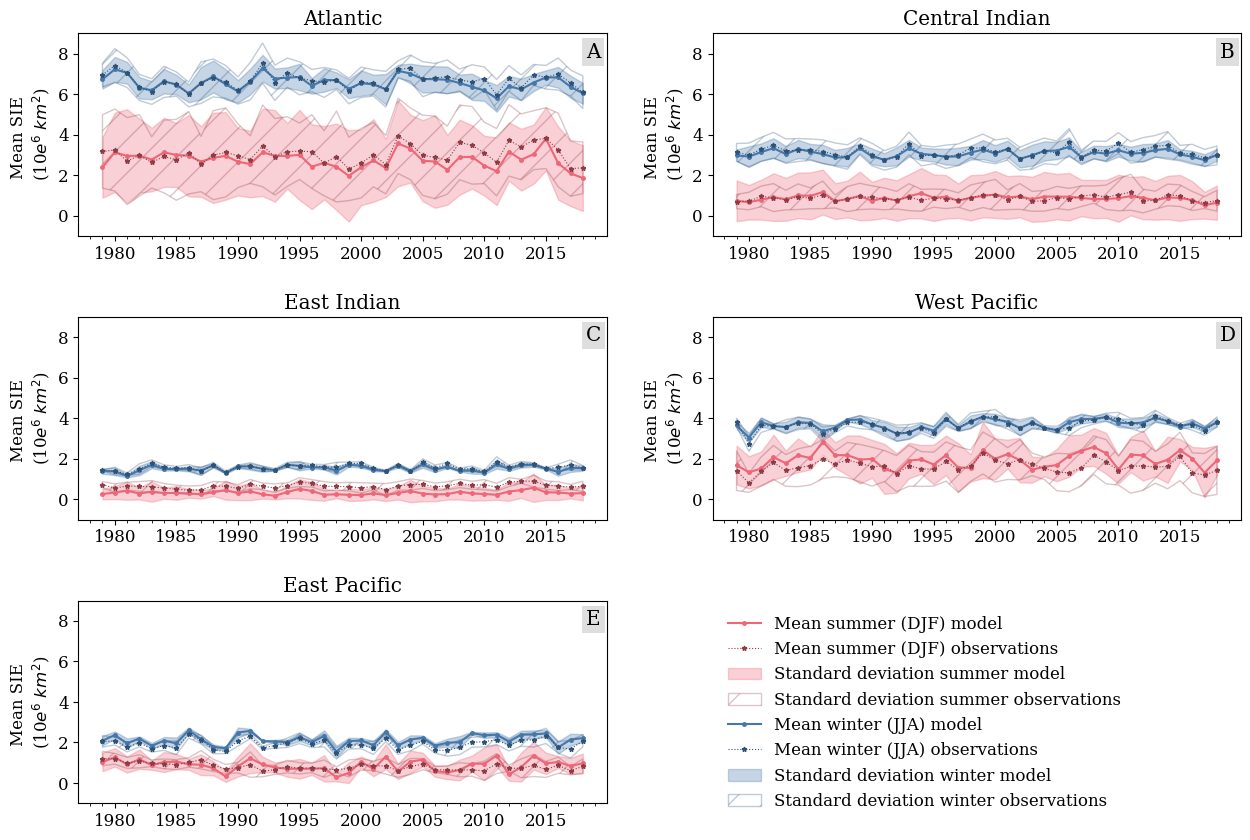

In [20]:
#Defining folder to save figure
out_folder = varDict['lm_fig']
os.makedirs(out_folder, exist_ok = True)

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.2, hspace = 0.4)

#Empty list to store axes 
ax = {}

for i, sec in enumerate(sectorNames):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    
    #Select data for each sector and change months to numeric values
    data_summer = seasonal_ts[f'{sec}_DJF']*1e-6
    data_winter = seasonal_ts[f'{sec}_JJA']*1e-6
    data_summer_obs = seasonal_ts_obs[f'{sec}_DJF']*1e-6
    data_winter_obs = seasonal_ts_obs[f'{sec}_JJA']*1e-6
        
    #Plotting values
    #Summer
    data_summer['mean'].plot(ax = ax[sec], color = '#ee6677', marker = 'o', 
                             markersize = 2.5, label = 'Mean summer (DJF) model')
    data_summer_obs['mean'].plot(ax = ax[sec], color = '#8e3d47', marker = '*', ls = 'dotted',
                             markersize = 3.5, label = 'Mean summer (DJF) observations', lw = 0.8)
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(data_summer['mean'].time.values, 
                         (data_summer['mean']+data_summer['std']).values,
                         (data_summer['mean']-data_summer['std']).values,
               alpha = 0.3, color = '#ee6677', label = 'Standard deviation summer model')
    ax[sec].fill_between(data_summer_obs['mean'].time.values, 
                         (data_summer_obs['mean']+data_summer_obs['std']).values,
                         (data_summer_obs['mean']-data_summer_obs['std']).values, color = 'none',                         
               alpha = 0.3, edgecolor = '#8e3d47', label = 'Standard deviation summer observations',
                        hatch = '/')
   
    #Winter
    data_winter['mean'].plot(ax = ax[sec], color = '#4477aa', marker = 'o', 
                             markersize = 2.5, label = 'Mean winter (JJA) model')
    data_winter_obs['mean'].plot(ax = ax[sec], color = '#2f5376', marker = '*', ls = 'dotted',
                             markersize = 3.5, label = 'Mean winter (JJA) observations', lw = 0.8)
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(data_winter['mean'].time.values, 
                         (data_winter['mean']+data_winter['std']).values,
                         (data_winter['mean']-data_winter['std']).values,
               alpha = 0.3, color = '#4477aa', label = 'Standard deviation winter model')
    ax[sec].fill_between(data_winter_obs['mean'].time.values, 
                         (data_winter_obs['mean']+data_winter_obs['std']).values,
                         (data_winter_obs['mean']-data_winter_obs['std']).values, color = 'none',
               hatch = '/', edgecolor = '#2f5376', label = 'Standard deviation winter observations',
                        alpha = 0.3)
       
    #Remove x axis label
    ax[sec].set_xlabel('')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Remove scientific notation from y axis and include it in label 
    exp_yaxis = int(np.floor(np.log10(int(data_winter['mean'].max().values))))
    plt.ylabel('Mean SIE \n' + r'(10$e^{}$ $km^2$)'.format(exp_yaxis))
    ax[sec].yaxis.get_offset_text().set_visible(False)
    ax[sec].set_ylim([-1e6, 9e6])
    ax[sec].xaxis.set_minor_locator(AutoMinorLocator(n = 5))
    
ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left', frameon = False)
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)
  
#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:5]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    if i < 5:
        ax[a].text(0.96, .88, labels[i], transform = ax[a].transAxes, fontsize = 'large',
           bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

#Saving figure
fn = 'SeasonalMeansSector_SeaIceExtent_1979-2018_inc_obs.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

## Plotting SIE autumn and spring timeseries - Figure A.2
Including observations and model derived SIE.

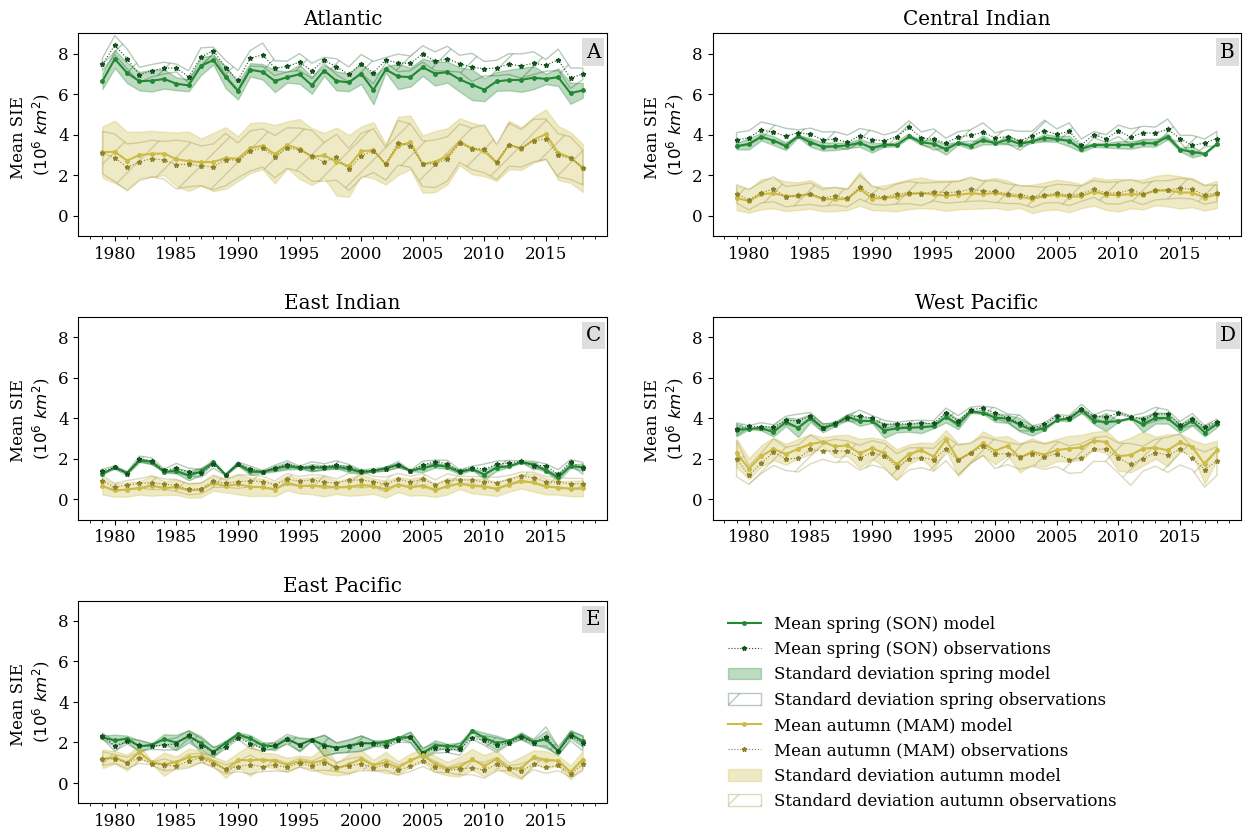

In [21]:
#Defining folder to save figure
out_folder = varDict['lm_fig']
os.makedirs(out_folder, exist_ok = True)

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.2, hspace = 0.4)

#Empty list to store axes 
ax = {}

for i, sec in enumerate(sectorNames):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    
    #Select data for each sector and change months to numeric values
    data_spring = seasonal_ts[f'{sec}_SON']*1e-6
    data_autumn = seasonal_ts[f'{sec}_MAM']*1e-6
    data_spring_obs = seasonal_ts_obs[f'{sec}_SON']*1e-6
    data_autumn_obs = seasonal_ts_obs[f'{sec}_MAM']*1e-6
        
    #Plotting values
    #Spring
    data_spring['mean'].plot(ax = ax[sec], color = '#228833', marker = 'o', 
                             markersize = 2.5, label = 'Mean spring (SON) model')
    data_spring_obs['mean'].plot(ax = ax[sec], color = '#14511e', marker = '*', ls = 'dotted',
                             markersize = 3.5, label = 'Mean spring (SON) observations', lw = 0.8)
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(data_spring['mean'].time.values, 
                         (data_spring['mean']+data_spring['std']).values,
                         (data_spring['mean']-data_spring['std']).values,
               alpha = 0.3, color = '#228833', label = 'Standard deviation spring model')
    ax[sec].fill_between(data_spring_obs['mean'].time.values, 
                         (data_spring_obs['mean']+data_spring_obs['std']).values,
                         (data_spring_obs['mean']-data_spring_obs['std']).values, color = 'none',
               alpha = 0.3, edgecolor = '#14511e', label = 'Standard deviation spring observations',
                        hatch = '/')
    
    #Autumn
    data_autumn['mean'].plot(ax = ax[sec], color = '#ccbb44', marker = 'o', 
                             markersize = 2.5, label = 'Mean autumn (MAM) model')
    data_autumn_obs['mean'].plot(ax = ax[sec], color = '#8e822f', marker = '*', ls = 'dotted', 
                                 markersize = 3.5, label = 'Mean autumn (MAM) observations', lw = 0.8)
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(data_autumn['mean'].time.values, 
                         (data_autumn['mean']+data_autumn['std']).values,
                         (data_autumn['mean']-data_autumn['std']).values,
               alpha = 0.3, color = '#ccbb44', label = 'Standard deviation autumn model')
    ax[sec].fill_between(data_autumn_obs['mean'].time.values, 
                         (data_autumn_obs['mean']+data_autumn_obs['std']).values,
                         (data_autumn_obs['mean']-data_autumn_obs['std']).values, color = 'none',
               alpha = 0.3, edgecolor = '#8e822f', label = 'Standard deviation autumn observations', 
                        hatch = '/')
       
    #Remove x axis label
    ax[sec].set_xlabel('')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Remove scientific notation from y axis and include it in label 
    exp_yaxis = int(np.floor(np.log10(int(data_spring['mean'].max().values))))
    plt.ylabel('Mean SIE \n' + r'($10^{}$ $km^2$)'.format(exp_yaxis))
    ax[sec].yaxis.get_offset_text().set_visible(False)
    ax[sec].set_ylim([-1e6, 9e6])
    ax[sec].xaxis.set_minor_locator(AutoMinorLocator(n = 5))
    
ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left', frameon = False)
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)
  
#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:5]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    if i < 5:
        ax[a].text(0.96, .88, labels[i], transform = ax[a].transAxes, fontsize = 'large',
           bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

#Saving figure
fn = 'SeasonalMeansSector_SON-MAM_SeaIceExtent_1979-2018_inc_obs.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Calculating monthly means for sea ice extent per MEASO sector

## From model outputs

In [22]:
# Empty dictionaries to hold results
#SIE
month_mean_mod = {}
month_std_mod = {}
#MIZ
month_mean_miz_mod = {}
month_std_miz_mod = {}

for sector in clipped_SIE:
    #SIE
    month_mean_mod[sector] = clipped_SIE[sector].groupby('time.month').mean()
    month_std_mod[sector] = clipped_SIE[sector].groupby('time.month').std()
    #MIZ
    month_mean_miz_mod[sector] = clipped_MIZ[sector].groupby('time.month').mean()
    month_std_miz_mod[sector] = clipped_MIZ[sector].groupby('time.month').std()

## From observations

In [23]:
# Empty dictionaries to hold results
#SIE
month_mean_obs = {}
month_std_obs = {}
#MIZ
month_mean_miz_obs = {}
month_std_miz_obs = {}

for sector in clipped_SIE_obs:
    #SIE
    month_mean_obs[sector] = clipped_SIE_obs[sector].groupby('time.month').mean()
    month_std_obs[sector] = clipped_SIE_obs[sector].groupby('time.month').std()
    #MIZ
    month_mean_miz_obs[sector] = clipped_MIZ_obs[sector].groupby('time.month').mean()
    month_std_miz_obs[sector] = clipped_MIZ_obs[sector].groupby('time.month').std()

## Plotting SIE comparisons - Figure A.1

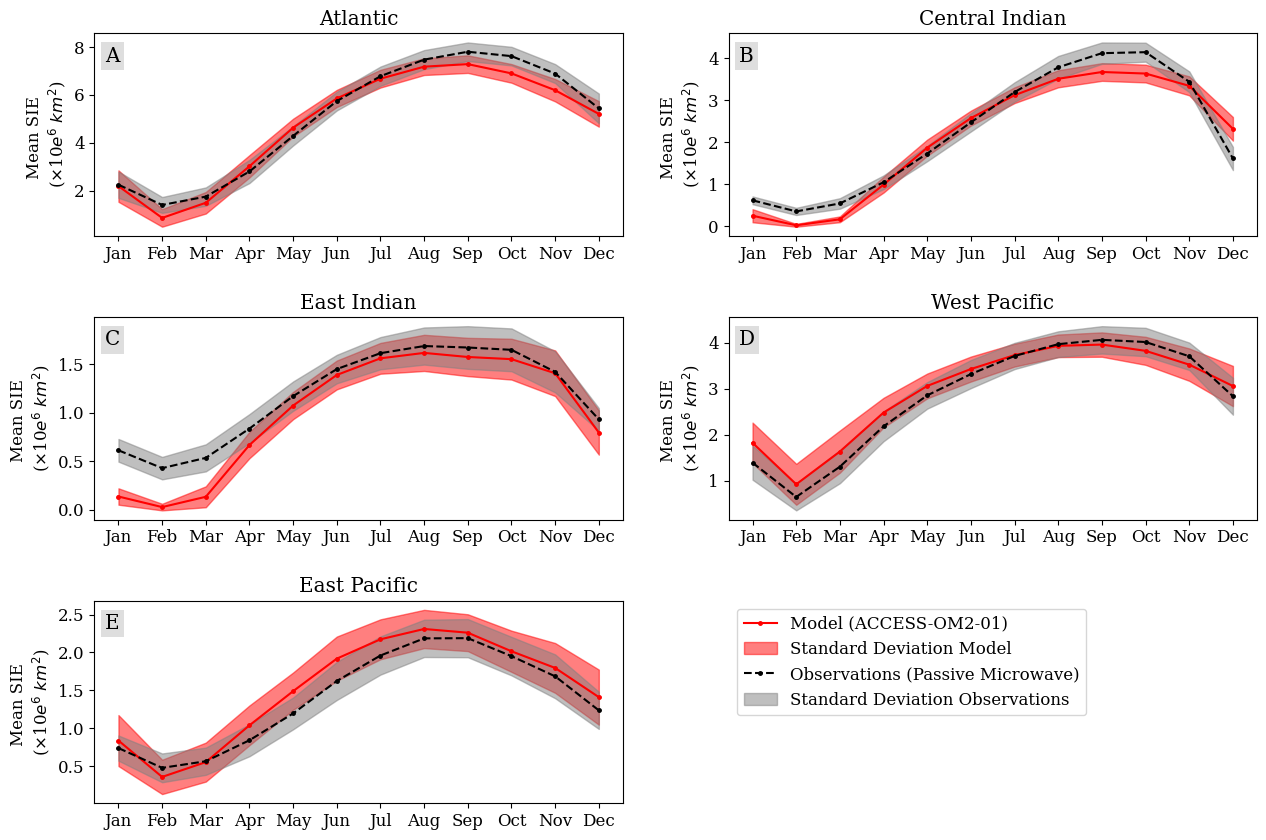

In [26]:
#Defining folder to save figure
out_folder = varDict['lm_fig']
os.makedirs(out_folder, exist_ok = True)

#Define max and min values for y axis
maxval = []
minval = []
for sec in month_mean_mod:
    maxval.append((month_mean_mod[sec].max()+month_std_mod[sec].max()).values)
    minval.append((month_mean_mod[sec].min()-month_std_mod[sec].max()).values)
    maxval.append((month_mean_obs[sec].max()+month_std_obs[sec].max()).values)
    minval.append((month_mean_obs[sec].min()-month_std_obs[sec].max()).values)
#Calculating max and min values to the nearest ten
maxval, minval = [(np.ceil(max(maxval)) + (1e12 - np.ceil(max(maxval))%1e12)), 
                  (np.floor(min(minval)) + (-1e12 - np.floor(min(minval))%1e12))]

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.2, hspace = 0.4)

#Empty list to store axes 
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, sec in enumerate(month_mean_mod):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    
    #Select data for each sector and change months to numeric values
    #Model data
    data = month_mean_mod[sec]
    data['month'] = np.arange(1, 13)
    #Observational data
    obs = month_mean_obs[sec]
    obs['month'] = np.arange(1, 13)
    
    #Extract information for each season and start plotting
    #Values multiplied by 1e-6 to transform from m2 to km2
    #Model data
    coef = (data*1e-6)
    se = (month_std_mod[sec]*1e-6)
    
    #Observational data
    coef_obs = (obs*1e-6)
    se_obs = (month_std_obs[sec]*1e-6)
    
    #Plotting values
    #Model data
    #Add trends as lines and highlight significance with markers
    coef.plot(ax = ax[sec], color = 'red', marker = 'o', markersize = 2.5, 
              label = 'Model (ACCESS-OM2-01)')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(coef.month, (coef+se).values, (coef-se).values,
               alpha = 0.5, color = 'red', label = 'Standard Deviation Model')
    
    #Observational data
    coef_obs.plot(ax = ax[sec], color = 'black', ls = '--', marker = 'o', markersize = 2.5,
                 label = 'Observations (Passive Microwave)')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(coef_obs.month, (coef_obs+se_obs).values, (coef_obs-se_obs).values,
               alpha = 0.5, color = 'gray', label = 'Standard Deviation Observations')
    
    #Remove x axis label
    ax[sec].set_xlabel('')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Show all ticks along the x axis
    plt.xticks(np.arange(1, 13))
    #Label x ticks as months
    ax[sec].set_xticklabels(calendar.month_abbr[1:])
    #Get remove scientific notation from y axis and include it in label 
    exp_yaxis = np.floor(np.log10(int(coef.max().values)))
    plt.ylabel('Mean SIE \n' + r'($\times$10$e^{}$ $km^2$)'.format(int(exp_yaxis)))
    ax[sec].yaxis.get_offset_text().set_visible(False)
    
ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left')
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)

#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:5]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    if i < 5:
        ax[a].text(0.02, .86, labels[i], transform = ax[a].transAxes, fontsize = 'large',
           bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

#Saving figure
fn = 'MonthlyMeansSector_SeaIceExtent_1979-2018.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, 
            bbox_inches = 'tight', 
            pad_inches = 0.05)

# Calculating monthly linear trends for SIE

## From model outputs

In [22]:
folder_out = os.path.join(varDict['linear_trends'], 'Monthly')
os.makedirs(folder_out, exist_ok = True)

LM_month_sec = {}

for sec in clipped_SIE:
    sub = clipped_SIE[sec].sel(time = slice('1979', '2018'))
    #Range of years included in data
    minY = sub.time.dt.year.values.min()
    maxY = sub.time.dt.year.values.max()
    coef_s = []
    se_s = []
    r_s = []
    p_s = []
    for month in range(1, 13):
        data = []
        for i, m in enumerate(sub.time.dt.month.values.tolist()):
            if m == month:
                data.append(sub[i])
        data = xr.concat(data, dim = 'time')
        time_ind = np.arange(0, len(data))
        #Extract values from SIC data and create a vector
        vals = data.values.tolist()
        #Save coefficients and pvalues for linear regression calculations
        slope, intercept, r, p, se = zsf.lm_yr(vals, time_ind)
        
        #Reshaping coefficients and pvalues to original dimensions of the data array
        coef_s.append(xr.DataArray(data = slope, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "coefficients"))
        se_s.append(xr.DataArray(data = se, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "std_err"))
        r_s.append(xr.DataArray(data = r, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "r_sq"))
        p_s.append(xr.DataArray(data = p, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "p_val"))
    #Concatening values before creating a data set
    coef_s = xr.concat(coef_s, dim = 'month')
    se_s = xr.concat(se_s, dim = 'month')
    r_s = xr.concat(r_s, dim = 'month')
    p_s = xr.concat(p_s, dim = 'month')
    
    #Creating data set
    LM_month_sec[sec] = xr.merge([coef_s, se_s, r_s, p_s])
    fn = f'MonthlyLinearTrend_SIE_{sec}.nc'
    LM_month_sec[sec].to_netcdf(os.path.join(folder_out, fn))

### Loading linear trends from model to avoid recalculating

In [27]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Monthly/*SIE*.nc'))

#Create empty list to save clipped data 
LM_month_sec = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    LM_month_sec[sector] = xr.open_dataset(fn[0])

## From observations

In [23]:
folder_out = os.path.join(varDict['linear_trends'], 'Monthly/Observations')
os.makedirs(folder_out, exist_ok = True)

LM_month_sec_obs = {}

for sec in clipped_SIE_obs:
    sub = clipped_SIE_obs[sec].sel(time = slice('1979', '2018'))
    #Range of years included in data
    minY = sub.time.dt.year.values.min()
    maxY = sub.time.dt.year.values.max()
    coef_s = []
    se_s = []
    r_s = []
    p_s = []
    for month in range(1, 13):
        data = []
        for i, m in enumerate(sub.time.dt.month.values.tolist()):
            if m == month:
                data.append(sub[i])
        data = xr.concat(data, dim = 'time')
        time_ind = np.arange(0, len(data))
        #Extract values from SIC data and create a vector
        vals = data.values.tolist()
        #Save coefficients and pvalues for linear regression calculations
        slope, intercept, r, p, se = zsf.lm_yr(vals, time_ind)
        
        #Reshaping coefficients and pvalues to original dimensions of the data array
        coef_s.append(xr.DataArray(data = slope, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "coefficients"))
        se_s.append(xr.DataArray(data = se, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "std_err"))
        r_s.append(xr.DataArray(data = r, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "r_sq"))
        p_s.append(xr.DataArray(data = p, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "p_val"))
    #Concatening values before creating a data set
    coef_s = xr.concat(coef_s, dim = 'month')
    se_s = xr.concat(se_s, dim = 'month')
    r_s = xr.concat(r_s, dim = 'month')
    p_s = xr.concat(p_s, dim = 'month')
    
    #Creating data set
    LM_month_sec_obs[sec] = xr.merge([coef_s, se_s, r_s, p_s])
    fn = f'MonthlyLinearTrend_Obs_SIE_{sec}.nc'
    LM_month_sec_obs[sec].to_netcdf(os.path.join(folder_out, fn))

### Loading linear trends from observations to avoid recalculation

In [28]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Monthly/Observations/*SIE*.nc'))

#Create empty list to save clipped data 
LM_month_sec_obs = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    LM_month_sec_obs[sector] = xr.open_dataset(fn[0])

# Calculating monthly linear trends for MIZ

## From model outputs

In [94]:
folder_out = os.path.join(varDict['linear_trends'], 'Monthly')
os.makedirs(folder_out, exist_ok = True)

LM_miz_month_sec = {}

for sec in clipped_MIZ:
    sub = clipped_MIZ[sec].sel(time = slice('1979', '2018'))
    #Range of years included in data
    minY = sub.time.dt.year.values.min()
    maxY = sub.time.dt.year.values.max()
    coef_s = []
    se_s = []
    r_s = []
    p_s = []
    for month in range(1, 13):
        data = []
        for i, m in enumerate(sub.time.dt.month.values.tolist()):
            if m == month:
                data.append(sub[i])
        data = xr.concat(data, dim = 'time')
        time_ind = np.arange(0, len(data))
        #Extract values from SIC data and create a vector
        vals = data.values.tolist()
        #Save coefficients and pvalues for linear regression calculations
        slope, intercept, r, p, se = zsf.lm_yr(vals, time_ind)
        
        #Reshaping coefficients and pvalues to original dimensions of the data array
        coef_s.append(xr.DataArray(data = slope, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "coefficients"))
        se_s.append(xr.DataArray(data = se, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "std_err"))
        r_s.append(xr.DataArray(data = r, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "r_sq"))
        p_s.append(xr.DataArray(data = p, dims = ['month'],
                              coords = dict(month = [calendar.month_abbr[month]]),
                              name = "p_val"))
    #Concatening values before creating a data set
    coef_s = xr.concat(coef_s, dim = 'month')
    se_s = xr.concat(se_s, dim = 'month')
    r_s = xr.concat(r_s, dim = 'month')
    p_s = xr.concat(p_s, dim = 'month')
    
    #Creating data set
    LM_miz_month_sec[sec] = xr.merge([coef_s, se_s, r_s, p_s])
    fn = f'MonthlyLinearTrend_MIZ_{sec}.nc'
    LM_miz_month_sec[sec].to_netcdf(os.path.join(folder_out, fn))

### Loading linear trends for MIZ to avoid recalculation

In [29]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Monthly/*MIZ*.nc'))

#Create empty list to save clipped data 
LM_miz_month_sec = {}

for sector in sectorNames:
    fn = [f for f in filelist if sector in f]
    LM_miz_month_sec[sector] = xr.open_dataset(fn[0])

# Plotting monthly SIE and MIZ trends for model data - Figure A.5

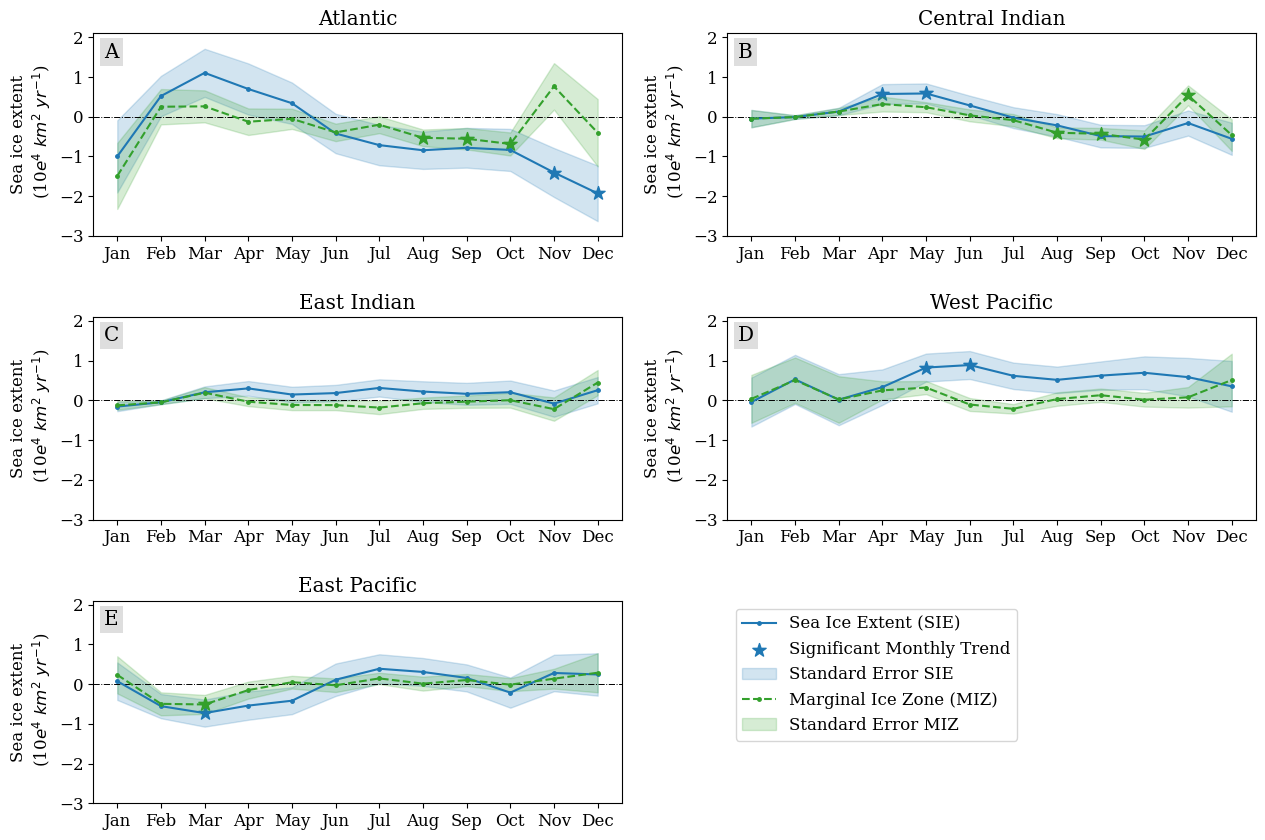

In [30]:
#Defining folder to save figure
out_folder = varDict['lm_fig']
os.makedirs(out_folder, exist_ok = True)

#Define max and min values for y axis
maxval = []
minval = []
for sec in LM_month_sec:
    data = LM_month_sec[sec]
    maxval.append((data.coefficients.max()+data.std_err.max()).values)
    minval.append((data.coefficients.min()-data.std_err.max()).values)
    data = LM_miz_month_sec[sec]
    maxval.append((data.coefficients.max()+data.std_err.max()).values)
    minval.append((data.coefficients.min()-data.std_err.max()).values)
#Calculating max and min values to the nearest ten
maxval, minval = [(np.ceil(max(maxval)) + (1e9 - np.ceil(max(maxval))%1e9)), 
                  (np.floor(min(minval)) + (-1e9 - np.floor(min(minval))%1e9))]

#Initialising figure
fig = plt.figure(figsize = (15, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create grid to show plots
gs = gridspec.GridSpec(nrows = 3, ncols = 2)

#Change the width between each plot
gs.update(wspace = 0.2, hspace = 0.4)

#Empty list to store axes 
ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, sec in enumerate(LM_month_sec):
    #Add each subplot
    ax[sec] = fig.add_subplot(gs[i])
    
    #Select data for each sector and change months to numeric values
    #Model data
    data = LM_month_sec[sec]
    data['month'] = np.arange(1, 13)
    #Observational data
    miz = LM_miz_month_sec[sec]
    miz['month'] = np.arange(1, 13)
    
    #Extract information for each season and start plotting
    #Values multiplied by 1e-6 to transform from m2 to km2
    #Model data
    coef = (data.coefficients*1e-6)
    se = (data.std_err*1e-6)
    sig = xr.where(data.p_val <= 0.05, coef, np.nan)
    
    #Observational data
    coef_miz = (miz.coefficients*1e-6)
    se_miz = (miz.std_err*1e-6)
    sig_miz = xr.where(miz.p_val <= 0.05, coef_miz, np.nan)
    
    #Plotting values
    #Model data
    #Adding horizontal line that makes it easier to distinguish positive and negative trends
    plt.axhline(y = 0, color = 'black', linestyle = '-.', lw = 0.7)
    #Add trends as lines and highlight significance with markers
    coef.plot(ax = ax[sec], color = '#1f78b4', marker = 'o', markersize = 2.5, 
              label = 'Sea Ice Extent (SIE)')
    plt.scatter(coef.month.values, sig, marker = '*', s = 100, c = '#1f78b4', label = 'Significant Monthly Trend')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(coef.month, (coef+se).values, (coef-se).values,
               alpha = 0.2, color = '#1f78b4', label = 'Standard Error SIE')
    
    #Observational data
    coef_miz.plot(ax = ax[sec], color = '#33a02c', ls = '--', marker = 'o', markersize = 2.5,
                 label = 'Marginal Ice Zone (MIZ)')
    plt.scatter(coef_miz.month.values, sig_miz, marker = '*', s = 100, c = '#33a02c')
    #Add standard errors in trend as shaded areas
    ax[sec].fill_between(coef_miz.month, (coef_miz+se_miz).values, (coef_miz-se_miz).values,
               alpha = 0.2, color = '#33a02c', label = 'Standard Error MIZ')
    
    #Remove x axis label
    ax[sec].set_xlabel('')
    #Setting title for each subplot
    ax[sec].set_title(f'{sec}')
    #Show all ticks along the x axis
    plt.xticks(np.arange(1, 13))
    #Label x ticks as months
    ax[sec].set_xticklabels(calendar.month_abbr[1:])
    #Set y axis limits and increase number of ticks
    ax[sec].set_ylim(minval*1e-6, (maxval*1e-6))
    ax[sec].yaxis.set_major_locator(MultipleLocator(10000))
    #Change to scientific notation for y axis label
    ax[sec].ticklabel_format(style = 'scientific', axis = 'y', scilimits = (0, 0))
    ax[sec].yaxis.get_offset_text().set_visible(False)
    exp_yaxis = int(np.floor(np.log10(maxval*1e-6)))
    #Set y axis label
    plt.ylabel(f'Sea ice extent\n (10$e^{exp_yaxis}$ ' + r'$km^{2}$ $yr^{-1}$)')
    
ax['legend'] = fig.add_subplot(gs[5])
h, l = ax[sec].get_legend_handles_labels()
ax['legend'].legend(h, l, loc = 'upper left')
[s.set_visible(False) for s in ax['legend'].spines.values()]
[t.set_visible(False) for t in ax['legend'].get_xticklines()]
[t.set_visible(False) for t in ax['legend'].get_yticklines()]
ax['legend'].yaxis.set_tick_params(labelleft = False)
ax['legend'].xaxis.set_tick_params(labelbottom = False)

#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:5]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    if i < 5:
        ax[a].text(0.02, .88, labels[i], transform = ax[a].transAxes, fontsize = 'large',
           bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

#Saving figure
fn = 'MonthlyLinearTrends_SIE-MIZ_1979-2018.png'
plt.savefig(os.path.join(out_folder, fn), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

# Calculating IQR per season and region for MIZ and SIE - (Table 2)
Calculations from model outputs in original grid.

In [31]:
#Create empty list to store calculations
sea_SIE = []
sea_MIZ = []

#Saving each sector as an entry in the dictionary
for sec in clipped_SIE:
    #Calculate quantiles calculated per season
    sea_SIE.append(clipped_SIE[sec].groupby('time.season').\
                   quantile([.25, .5, .75]).expand_dims({'region': [sec]}))
    sea_MIZ.append(clipped_MIZ[sec].groupby('time.season').\
                   quantile([.25, .5, .75]).expand_dims({'region': [sec]}))

#Create a data array from list
sea_SIE = xr.combine_by_coords(sea_SIE)
sea_MIZ = xr.combine_by_coords(sea_MIZ)

## Re-arranging IQR summaries in a data frame for easy exporting

In [32]:
reg_sea_SIEpd = []
reg_sea_MIZpd = []

seasonNames = {'Summer': 'DJF', 'Autumn': 'MAM', 
              'Winter': 'JJA', 'Spring': 'SON'}
for sea in seasonNames:
    #Values multiplied by 1e-6 to transform from m2 to km2
    x = (sea_SIE.sel(season = seasonNames[sea])*1e-6).to_pandas()
    x['season'] = sea
    reg_sea_SIEpd.append(x)
    y = (sea_MIZ.sel(season = seasonNames[sea])*1e-6).to_pandas()
    y['season'] = sea
    reg_sea_MIZpd.append(y)

reg_sea_SIEpd = pd.concat(reg_sea_SIEpd)
reg_sea_MIZpd = pd.concat(reg_sea_MIZpd)
reg_sea_SIEpd

quantile,0.25,0.5,0.75,season
region,,,,
Atlantic,1.034635e+06,2.111917e+06,4.882623e+06,Summer
Central Indian,2.358325e+04,2.277376e+05,2.131334e+06,Summer
East Indian,3.282893e+04,1.457181e+05,6.180520e+05,Summer
East Pacific,4.444018e+05,7.797129e+05,1.266234e+06,Summer
West Pacific,1.123237e+06,1.851512e+06,2.762690e+06,Summer
Atlantic,1.787096e+06,2.951981e+06,4.419868e+06,Autumn
Central Indian,2.187052e+05,9.777661e+05,1.696719e+06,Autumn
East Indian,1.675878e+05,6.800431e+05,9.379166e+05,Autumn
East Pacific,6.902298e+05,1.052548e+06,1.391052e+06,Autumn


In [33]:
reg_sea_MIZpd

quantile,0.25,0.5,0.75,season
region,,,,
Atlantic,7.166460e+05,1.806124e+06,3.462883e+06,Summer
Central Indian,2.199946e+04,2.174369e+05,2.014421e+06,Summer
East Indian,3.277525e+04,1.416267e+05,5.738847e+05,Summer
East Pacific,4.237599e+05,7.191975e+05,1.065335e+06,Summer
West Pacific,1.077424e+06,1.653497e+06,2.023841e+06,Summer
Atlantic,9.292309e+05,1.134550e+06,1.316620e+06,Autumn
Central Indian,2.129599e+05,6.813931e+05,8.263630e+05,Autumn
East Indian,1.590686e+05,3.664663e+05,4.175362e+05,Autumn
East Pacific,3.713568e+05,4.811702e+05,5.688974e+05,Autumn


# Calculating RMSE for SIE and MIZ

## Calculating SIE and MIZ from regridded model data

In [84]:
fn = os.path.join(varDict['base_data'], 'Regridded/SIC_regridded-mod_all_1979-2018.nc')
SIC_reg = xr.open_dataarray(fn)

#Only keep area pixels where sea ice concentration is 15% or more for SIE
SIE_reg = xr.where(SIC_reg >= 0.15, (25000**2), np.nan)

#Keep area pixels where sea ice concentration is between 15% and 80% for MIZ
MIZ_reg = xr.where(((SIC_reg >= 0.15) & (SIC_reg <= 0.8)), (25000**2), np.nan)

## Clipping regridded model data using MEASO shapefile

In [87]:
#Assigning CRS to observational data
SIE_reg.rio.set_spatial_dims(x_dim = 'xgrid', y_dim = 'ygrid', inplace = True)
SIE_reg.rio.write_crs(MEASO_fixed.crs, inplace = True)

MIZ_reg.rio.set_spatial_dims(x_dim = 'xgrid', y_dim = 'ygrid', inplace = True)
MIZ_reg.rio.write_crs(MEASO_fixed.crs, inplace = True)

<xarray.DataArray (time: 480, ygrid: 332, xgrid: 316)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time         (time) datetime64[ns] 1978-12-31T12:00:00 ... 2018-11-30T12:...
    lat          (ygrid, xgrid) float64 -39.36 -39.49 -39.62 ... -41.72 -41.58
    lon          (ygrid, xgrid) float64 -42.23 -42.05 -41.87 ... 135.2 135.0
  * ygrid        (ygrid) float32 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
  * xgrid        (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
    spatial_ref  int64 0

## Clipping regridded data

In [90]:
#Ensuring output folder exists
out_folder = os.path.join(varDict['clipped_data'], 'Regridded')
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Range of years included in data
minY = SIE_reg.time.dt.year.values.min()
maxY = SIE_reg.time.dt.year.values.max()

#Empty list to store clipped data 
clipped_SIE_reg = {}
clipped_MIZ_reg = {}

#Clipping data using MEASO sectors
for sec in np.unique(MEASO.sector):
    shp = MEASO.query(f'sector == "{sec}"')
    #SIE
    clipped_SIE_reg[sec] = SIE_reg.rio.clip(shp.geometry, invert = False)
    clipped_SIE_reg[sec] = clipped_SIE_reg[sec].sum(('xgrid', 'ygrid'))
    fn = f'SeaIceExtent_Reg_{sec}_{minY}-{maxY}.nc'
    clipped_SIE_reg[sec].to_netcdf(os.path.join(out_folder, fn))
    #MIZ
    clipped_MIZ_reg[sec] = MIZ_reg.rio.clip(shp.geometry, invert = False)
    clipped_MIZ_reg[sec] = clipped_MIZ_reg[sec].sum(('xgrid', 'ygrid'))
    fn_m = f'MIZ_Reg_{sec}_{minY}-{maxY}.nc'
    clipped_MIZ_reg[sec].to_netcdf(os.path.join(out_folder, fn_m))

### Loading clipped regridded data to avoid recalculation

In [48]:
filelist = glob(os.path.join(varDict['clipped_data'], 'Regridded/*Extent*2018.nc'))
filelist_m = glob(os.path.join(varDict['clipped_data'], 'Regridded/*MIZ*2018.nc'))

#Create empty list to save clipped data 
clipped_SIE_reg = {}
clipped_MIZ_reg = {}

for sector in sectorNames:
    #SIE
    fn = [f for f in filelist if sector in f]
    clipped_SIE_reg[sector] = xr.open_dataarray(fn[0])
    #MIZ
    fn_m = [f for f in filelist_m if sector in f]
    clipped_MIZ_reg[sector] = xr.open_dataarray(fn_m[0])

## Applying RMSE equation

### Marginal Ice Zone

In [117]:
#Starting empty dictionaries to store calculations
rmse = {}
obs_sea = {}
mod_sea = {}

#Loop through each sector and applying conversion from m2 to km2
for sector in clipped_MIZ_obs:
    #Looping through seasons
    for s, da in (clipped_MIZ_obs[sector]*1e-6).groupby('time.season'):
        obs_sea[f'{sector}_{s}'] = da.values
    for s, da in (clipped_MIZ_reg[sector]*1e-6).groupby('time.season'):
        mod_sea[f'{sector}_{s}'] = da.values
        #Calculating RMSE per season and sector
        rmse[f'{sector}_{s}'] = np.sqrt(np.mean((obs_sea[f'{sector}_{s}']-mod_sea[f'{sector}_{s}'])**2))

In [118]:
rmse

{'Atlantic_DJF': 720234.4973130568,
 'Atlantic_JJA': 196404.4310112003,
 'Atlantic_MAM': 228757.30720341665,
 'Atlantic_SON': 303581.0519089177,
 'Central Indian_DJF': 706202.4435500359,
 'Central Indian_JJA': 123663.26927049384,
 'Central Indian_MAM': 209634.85895370948,
 'Central Indian_SON': 450642.7592721035,
 'East Indian_DJF': 275613.31938590464,
 'East Indian_JJA': 99805.67055533468,
 'East Indian_MAM': 165108.35299634803,
 'East Indian_SON': 192531.71241761275,
 'West Pacific_DJF': 654982.3346655682,
 'West Pacific_JJA': 83283.29226701676,
 'West Pacific_MAM': 198701.53038435144,
 'West Pacific_SON': 189455.56592070166,
 'East Pacific_DJF': 410689.5679512183,
 'East Pacific_JJA': 102154.25363859467,
 'East Pacific_MAM': 119114.79057335127,
 'East Pacific_SON': 141055.00229298853}

### Sea Ice Extent

In [119]:
#Starting empty dictionaries to store calculations
rmse = {}
obs_sea = {}
mod_sea = {}

#Loop through each sector and applying conversion from m2 to km2
for sector in clipped_SIE_obs:
    #Looping through seasons
    for s, da in (clipped_SIE_obs[sector]*1e-6).groupby('time.season'):
        obs_sea[f'{sector}_{s}'] = da.values
    for s, da in (clipped_SIE_reg[sector]*1e-6).groupby('time.season'):
        mod_sea[f'{sector}_{s}'] = da.values
        #Calculating RMSE per season and sector
        rmse[f'{sector}_{s}'] = np.sqrt(np.mean((obs_sea[f'{sector}_{s}']-mod_sea[f'{sector}_{s}'])**2))

In [120]:
rmse

{'Atlantic_DJF': 544512.961493457,
 'Atlantic_JJA': 303281.48881580844,
 'Atlantic_MAM': 400796.44423764746,
 'Atlantic_SON': 389349.5928709185,
 'Central Indian_DJF': 584055.9679499189,
 'Central Indian_JJA': 184375.37076233907,
 'Central Indian_MAM': 271622.56599806837,
 'Central Indian_SON': 273493.27407368115,
 'East Indian_DJF': 387692.9836989251,
 'East Indian_JJA': 71688.23107008802,
 'East Indian_MAM': 259465.75345031888,
 'East Indian_SON': 114864.95694219945,
 'West Pacific_DJF': 501689.86246381176,
 'West Pacific_JJA': 145305.27535803715,
 'West Pacific_MAM': 353111.90978687385,
 'West Pacific_SON': 167920.47271327578,
 'East Pacific_DJF': 292062.86891873414,
 'East Pacific_JJA': 300028.611916847,
 'East Pacific_MAM': 262070.9290917251,
 'East Pacific_SON': 180293.3716745895}